In [3]:
import pandas as pd
import numpy as np

import sys
import os

# Get the current working directory (where the notebook is running)
notebook_dir = os.getcwd()

# Go up one level to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now you can import your module
from utils import factor_model_solution, factor_goodness_of_fit_test

In [4]:
df_gene_effect = pd.read_csv("preprocessed_data/20Q4v2_Achilles_gene_effect.csv")
df_correlations = {
    "DICER1": pd.read_csv("preprocessed_data/corr_DICER1_preprocessed.csv", delimiter=";"),
    "GART": pd.read_csv("preprocessed_data/corr_GART_preprocessed.csv", delimiter=";")
}

In [5]:

# Number of genes to include from each corr file taking top X // 2 and bottom X // 2.
# Note that the same gene may be selected in both corr files. (But will only appear once in the final selected_genes list.)
number_of_genes = 10
assert number_of_genes % 2 == 0, "number_of_genes should be an even number."

selected_columns = pd.concat(
    [df_correlations["DICER1"]["gene_evaluated"][:number_of_genes // 2], 
     df_correlations["DICER1"]["gene_evaluated"][-number_of_genes // 2:]]
    ).to_list()
selected_columns = set(selected_columns)

# number_of_genes multiplied by how many corr files we have.
number_of_duplicates = (number_of_genes * len(df_correlations)) - len(selected_columns) 
if number_of_duplicates > 0:
    print(f"Warning: {number_of_duplicates} duplicates were removed.")

# Extract gene names according to the format of gene_effect dataset.
selected_columns_gene_effect_format = [column for column in df_gene_effect.columns if column.split(" ")[0] in selected_columns]

# Rough automatic check for whether we found all corresponding columns in gene_effect dataset that we've selected.
assert len(selected_columns) == len(selected_columns_gene_effect_format)

# Extract columns from gene_effect dataset.
X = df_gene_effect[selected_columns_gene_effect_format].dropna() # Is dropping rows with na a good idea? Maybe use mean value instead?
X = X.to_numpy()
num_dropped_rows = df_gene_effect.shape[0] - X.shape[0]
if num_dropped_rows > 0:
    print(f"Warning: {num_dropped_rows} rows contained at least 1 NA and was dropped.")
X.shape

(808, 10)

In [6]:
df_gene_effect.shape

(808, 18120)

In [7]:
df_gene_effect.iloc[:, 1]

0      0.181332
1     -0.076383
2      0.102195
3      0.142342
4      0.280082
         ...   
803    0.089323
804   -0.019394
805   -0.061388
806    0.049819
807    0.156697
Name: A1BG (1), Length: 808, dtype: float64

In [10]:
described = df_gene_effect.describe()

In [ ]:
described

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,789.000000,789.000000,808.000000,808.000000,808.000000,808.000000,808.000000,796.000000
mean,0.111314,0.070376,-0.056075,0.180158,-0.037762,-0.044093,0.118733,-0.512781,0.076057,0.162007,...,-0.111751,-0.549633,0.015018,0.059851,0.106475,0.078253,-0.184343,0.123015,-0.166244,-0.385952
std,0.125112,0.122324,0.108705,0.121511,0.146597,0.128245,0.118202,0.179457,0.129945,0.133700,...,0.164716,0.241310,0.153490,0.167696,0.136733,0.125821,0.136777,0.135319,0.150837,0.169842
min,-0.499506,-0.749276,-0.495425,-0.353756,-0.731474,-0.674052,-0.236621,-1.479991,-0.740168,-0.459333,...,-0.921473,-1.410735,-0.750230,-1.442541,-0.424745,-0.343132,-0.864628,-0.652634,-0.660907,-1.226509
25%,0.044962,0.002850,-0.116077,0.112008,-0.116987,-0.117890,0.047510,-0.614495,0.011360,0.093037,...,-0.210429,-0.711179,-0.076770,-0.023387,0.033414,0.000468,-0.260863,0.050793,-0.247219,-0.492425
50%,0.115773,0.073970,-0.057581,0.181638,-0.033001,-0.042821,0.118808,-0.497529,0.082979,0.160690,...,-0.109786,-0.567882,0.019500,0.064865,0.107404,0.078829,-0.181250,0.136886,-0.160806,-0.381071
75%,0.185971,0.136145,0.004333,0.237688,0.044950,0.028593,0.189796,-0.396008,0.152466,0.234858,...,-0.006667,-0.395498,0.110572,0.158371,0.184274,0.149775,-0.108572,0.211252,-0.083073,-0.286698
max,0.798506,0.530583,0.581334,1.016989,0.774305,0.696779,0.765730,0.018836,0.696792,0.820783,...,0.677736,0.578194,0.950778,0.790275,1.119069,1.210021,0.513621,0.505003,0.823686,0.374475


: 

In [16]:
described.loc["max"].min()

-1.515663394087531

<AxesSubplot: >

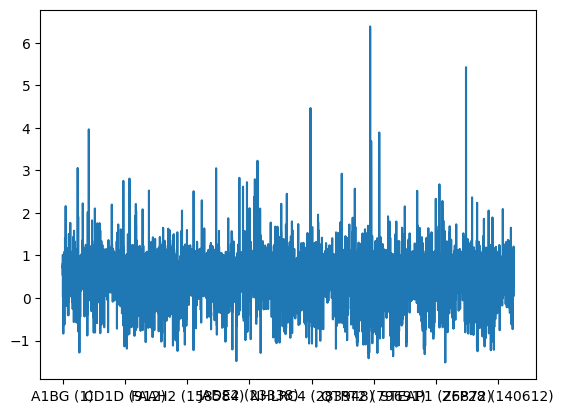

In [17]:
described.loc["max"].plot()

<AxesSubplot: >

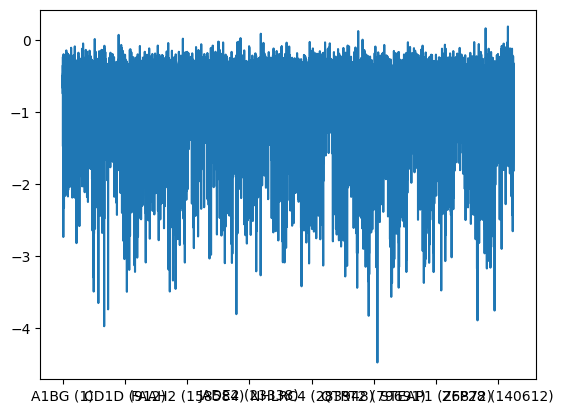

In [18]:
described.loc["min"].plot()

In [130]:
import random
from random import randrange

random.seed(1)

amount_of_columns = df_gene_effect.shape[1]

total_genes = 200

column_integers = [randrange(0, amount_of_columns-1) for _ in range(total_genes)]

In [131]:

X = df_gene_effect.iloc[:, column_integers].dropna() # Is dropping rows with na a good idea? Maybe use mean value instead?
X = X.to_numpy()
num_dropped_rows = df_gene_effect.shape[0] - X.shape[0]
if num_dropped_rows > 0:
    print(f"Warning: {num_dropped_rows} rows contained at least 1 NA and was dropped.")
X.shape

(778, 200)

In [132]:
abs(X).min()

1.6046194597093193e-07

In [133]:
_, lambda_hat = factor_model_solution(X, k = 10)
lambda_hat

c:\Users\lucas\Desktop\6 semester\Bachelor project\Bachelorprojekt\Bachelorprojekt\utils.py:110: RuntimeWarning: invalid value encountered in log
  result = np.trace(internal) - np.log(np.linalg.det(internal)) - p
C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx


array([[-0.06247487,  0.07601588, -0.02801143, ...,  0.0298711 ,
         0.00181959, -0.0136996 ],
       [-0.12379197,  0.02249196,  0.03559324, ...,  0.02014321,
        -0.07402811, -0.01632061],
       [-0.05979765, -0.04408751, -0.05148708, ...,  0.02906055,
        -0.01621574,  0.00665314],
       ...,
       [-0.13483303, -0.03700727,  0.01729237, ..., -0.00905964,
         0.07219539, -0.00914646],
       [-0.0718263 ,  0.08336453,  0.00824842, ...,  0.03964243,
        -0.02036025,  0.00611225],
       [-0.06100769, -0.05294257,  0.06679201, ..., -0.05035684,
         0.02644643,  0.0199857 ]])

In [134]:
lambda_hat[0], len(lambda_hat[0])

(array([-0.06247487,  0.07601588, -0.02801143, -0.06977072, -0.0853575 ,
         0.02726702, -0.03758339,  0.0298711 ,  0.00181959, -0.0136996 ]),
 10)

In [135]:
loadings = lambda_hat.T
lambda_hat[1]

array([-0.12379197,  0.02249196,  0.03559324,  0.04071055, -0.02902519,
        0.01857414,  0.00435108,  0.02014321, -0.07402811, -0.01632061])

In [136]:
genes = [column_name.split(" ")[0] for column_name in df_gene_effect.iloc[:, column_integers].columns.to_list()]

df_values = pd.DataFrame({
    'gene_evaluated': genes})

In [137]:
for i in range(loadings.shape[0]):
    df_values[f"loading {i}"] = loadings[i]



In [138]:
df_values

,gene_evaluated,loading 0,loading 1,loading 2,loading 3,loading 4,loading 5,loading 6,loading 7,loading 8,loading 9
0,DUS3L,-0.062475,0.076016,-0.028011,-0.069771,-0.085357,0.027267,-0.037583,0.029871,0.001820,-0.013700
1,CACNG6,-0.123792,0.022492,0.035593,0.040711,-0.029025,0.018574,0.004351,0.020143,-0.074028,-0.016321
2,LLGL2,-0.059798,-0.044088,-0.051487,-0.122082,0.028933,-0.080002,-0.034611,0.029061,-0.016216,0.006653
3,DCAF12L2,-0.040923,0.055217,0.045019,0.065959,0.090989,0.028127,-0.002226,-0.003645,-0.030486,-0.002190
4,TPM4,-0.011025,-0.010260,-0.033018,0.036545,-0.004740,-0.018080,0.019867,-0.021165,-0.017105,-0.017000
...,...,...,...,...,...,...,...,...,...,...,...
195,LGALS8,-0.004611,0.082208,-0.065195,0.028590,-0.081759,-0.119024,-0.035228,0.015752,0.035097,0.003735
196,DNPEP,-0.021077,0.083674,0.113836,-0.066728,-0.039355,-0.035804,0.000670,0.004033,-0.033232,0.023127
197,ADAMTS2,-0.134833,-0.037007,0.017292,-0.032754,0.039856,0.016412,0.020302,-0.009060,0.072195,-0.009146
198,ATP6V0A4,-0.071826,0.083365,0.008248,-0.017228,0.002694,-0.031007,0.060006,0.039642,-0.020360,0.006112


In [139]:
for i in range(1, loadings.shape[0]+1):
    values = df_values.iloc[:, lambda values: [0, i]]
    values = values.set_index("gene_evaluated").sort_values(values.columns[1], ascending = False)[:10]
    print(values)
    

                loading 0
gene_evaluated           
SFTA2            0.266710
SFTA2            0.266710
ARHGEF26         0.228638
PKLR             0.186090
UNC79            0.167469
LILRA1           0.160019
ABCF1            0.145388
COQ2             0.126293
TMF1             0.111147
SPZ1             0.108500
                loading 1
gene_evaluated           
CFAP36           0.193401
ATG10            0.179070
PDS5B            0.157478
ANKRD16          0.154384
FMR1NB           0.153436
ZNF706           0.150958
NKIRAS1          0.138464
GNG12            0.138279
SPZ1             0.137327
VRK2             0.123680
                loading 2
gene_evaluated           
QPRT             0.149548
SCN2B            0.144031
DNPEP            0.113836
FOXL2NB          0.112075
RPP25            0.104016
NAT16            0.100849
FMR1NB           0.093579
FAM98B           0.090132
ILDR2            0.088586
PQBP1            0.087125
                loading 3
gene_evaluated           
ZNF229      